# XGBoost feature interactions demo

This demo demonstrates how to use two XGBoost improvements using H2O XGBoost integration - **feature interaction contraints** and geting **feature interactions** from the model.

**More information:**

- H2O XGboost interaction constraints documentation: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/interaction_constraints.html
- Native XGBoost interaction contraints tutorial: https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html
- H2O XGboost feature interaction documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost-feature-interactions
- Original XGBFI package: https://github.com/Far0n/xgbfi


## Feature Interaction Constraints

Feature interaction constraints allow users to decide which variables are allowed to interact and which are not.

**Potential benefits include:**

- Better predictive performance from focusing on interactions that work – whether through domain specific knowledge or algorithms that rank interactions
- Less noise in predictions; better generalization
- More control to the user on what the model can fit. For example, the user may want to exclude some interactions even if they perform well due to regulatory constraints

(Source: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/interaction_constraints.html)

In [2]:
# start h2o
import h2o
h2o.init(strict_version_check=False, port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 34 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.850 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
# method to print tree structure
def print_tree(tree):
    import numpy as np
    tree = H2OTree(model, 0)
    n_nodes = tree.__len__()
    children_left = tree.left_children
    children_right = tree.right_children
    feature = tree.features
    threshold = tree.thresholds


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
    print()


In [4]:
from h2o.estimators.xgboost import *
# check if the H2O XGBoostEstimator is available
assert H2OXGBoostEstimator.available() is True

# import data
data = h2o.import_file(path = "../../smalldata/logreg/prostate.csv")

x = list(range(1, data.ncol-2))
y = data.names[len(data.names) - 1]

ntree = 5

h2o_params = {
    'eta': 0.3, 
    'max_depth': 3,  
    'ntrees': ntree,
    'tree_method': 'hist'
} 

# define interactions as a list of list of names of colums
# the lists defines allowed interaction
# the interactions of each column with itself are always allowed
# so you cannot specified list with one column e.g. ["PSA"]
h2o_params["interaction_constraints"] = [["CAPSULE", "AGE"], ["PSA", "DPROS"]]

# train h2o XGBoost model
h2o_model = H2OXGBoostEstimator(**h2o_params)
h2o_model.train(x=x, y=y, training_frame=data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [5]:
# check the trees have allowed structure
# so in each tree can be as split feature only 
from h2o.tree import H2OTree
for i in range(0, ntree):
    print("Tree index:"+str(i))
    tree = H2OTree(h2o_model, i)
    for i in range(0, len(tree)):
        print("Node ID {0} has left child node with index {1} and right child node with index {2}. The split feature is {3}."
          .format(tree.node_ids[i], tree.left_children[i], tree.right_children[i], tree.features[i]))
    

Tree index:0
Node ID 0 has left child node with index 1 and right child node with index 2. The split feature is CAPSULE.
Node ID 1 has left child node with index -1 and right child node with index -1. The split feature is None.
Node ID 2 has left child node with index -1 and right child node with index -1. The split feature is None.
Tree index:1
Node ID 0 has left child node with index 1 and right child node with index 2. The split feature is PSA.
Node ID 1 has left child node with index 3 and right child node with index 4. The split feature is PSA.
Node ID 2 has left child node with index -1 and right child node with index -1. The split feature is None.
Node ID 3 has left child node with index 5 and right child node with index 6. The split feature is DPROS.
Node ID 4 has left child node with index -1 and right child node with index -1. The split feature is None.
Node ID 5 has left child node with index -1 and right child node with index -1. The split feature is None.
Node ID 6 has lef

In [6]:
try:
    import xgboost as xgb
    import pandas as pd
    data = pd.read_csv("../../smalldata/logreg/prostate.csv")

    y = data["GLEASON"]
    x_names = data.columns.to_list()
    x_names.remove("GLEASON")
    x_names.remove("ID")
    x = data[x_names]


    D_train = xgb.DMatrix(x, label=y)

    param = {
        'eta': 0.3, 
        'max_depth': 3,  
        'interaction_constraints': '[[0,1], [3, 5]]', # same as [["CAPSULE", "AGE"], ["PSA", "DPROS"]]
        'tree_method': 'hist'
    } 

    steps = ntree

    xgboost_model = xgb.train(param, D_train, steps)
    # you can compare the H2O XGBoost and native XGBoost have the same tree structure
    xgboost_model.trees_to_dataframe()
except ImportError:
    print("module 'xgboost' is not installed")
    xgboost_model = None

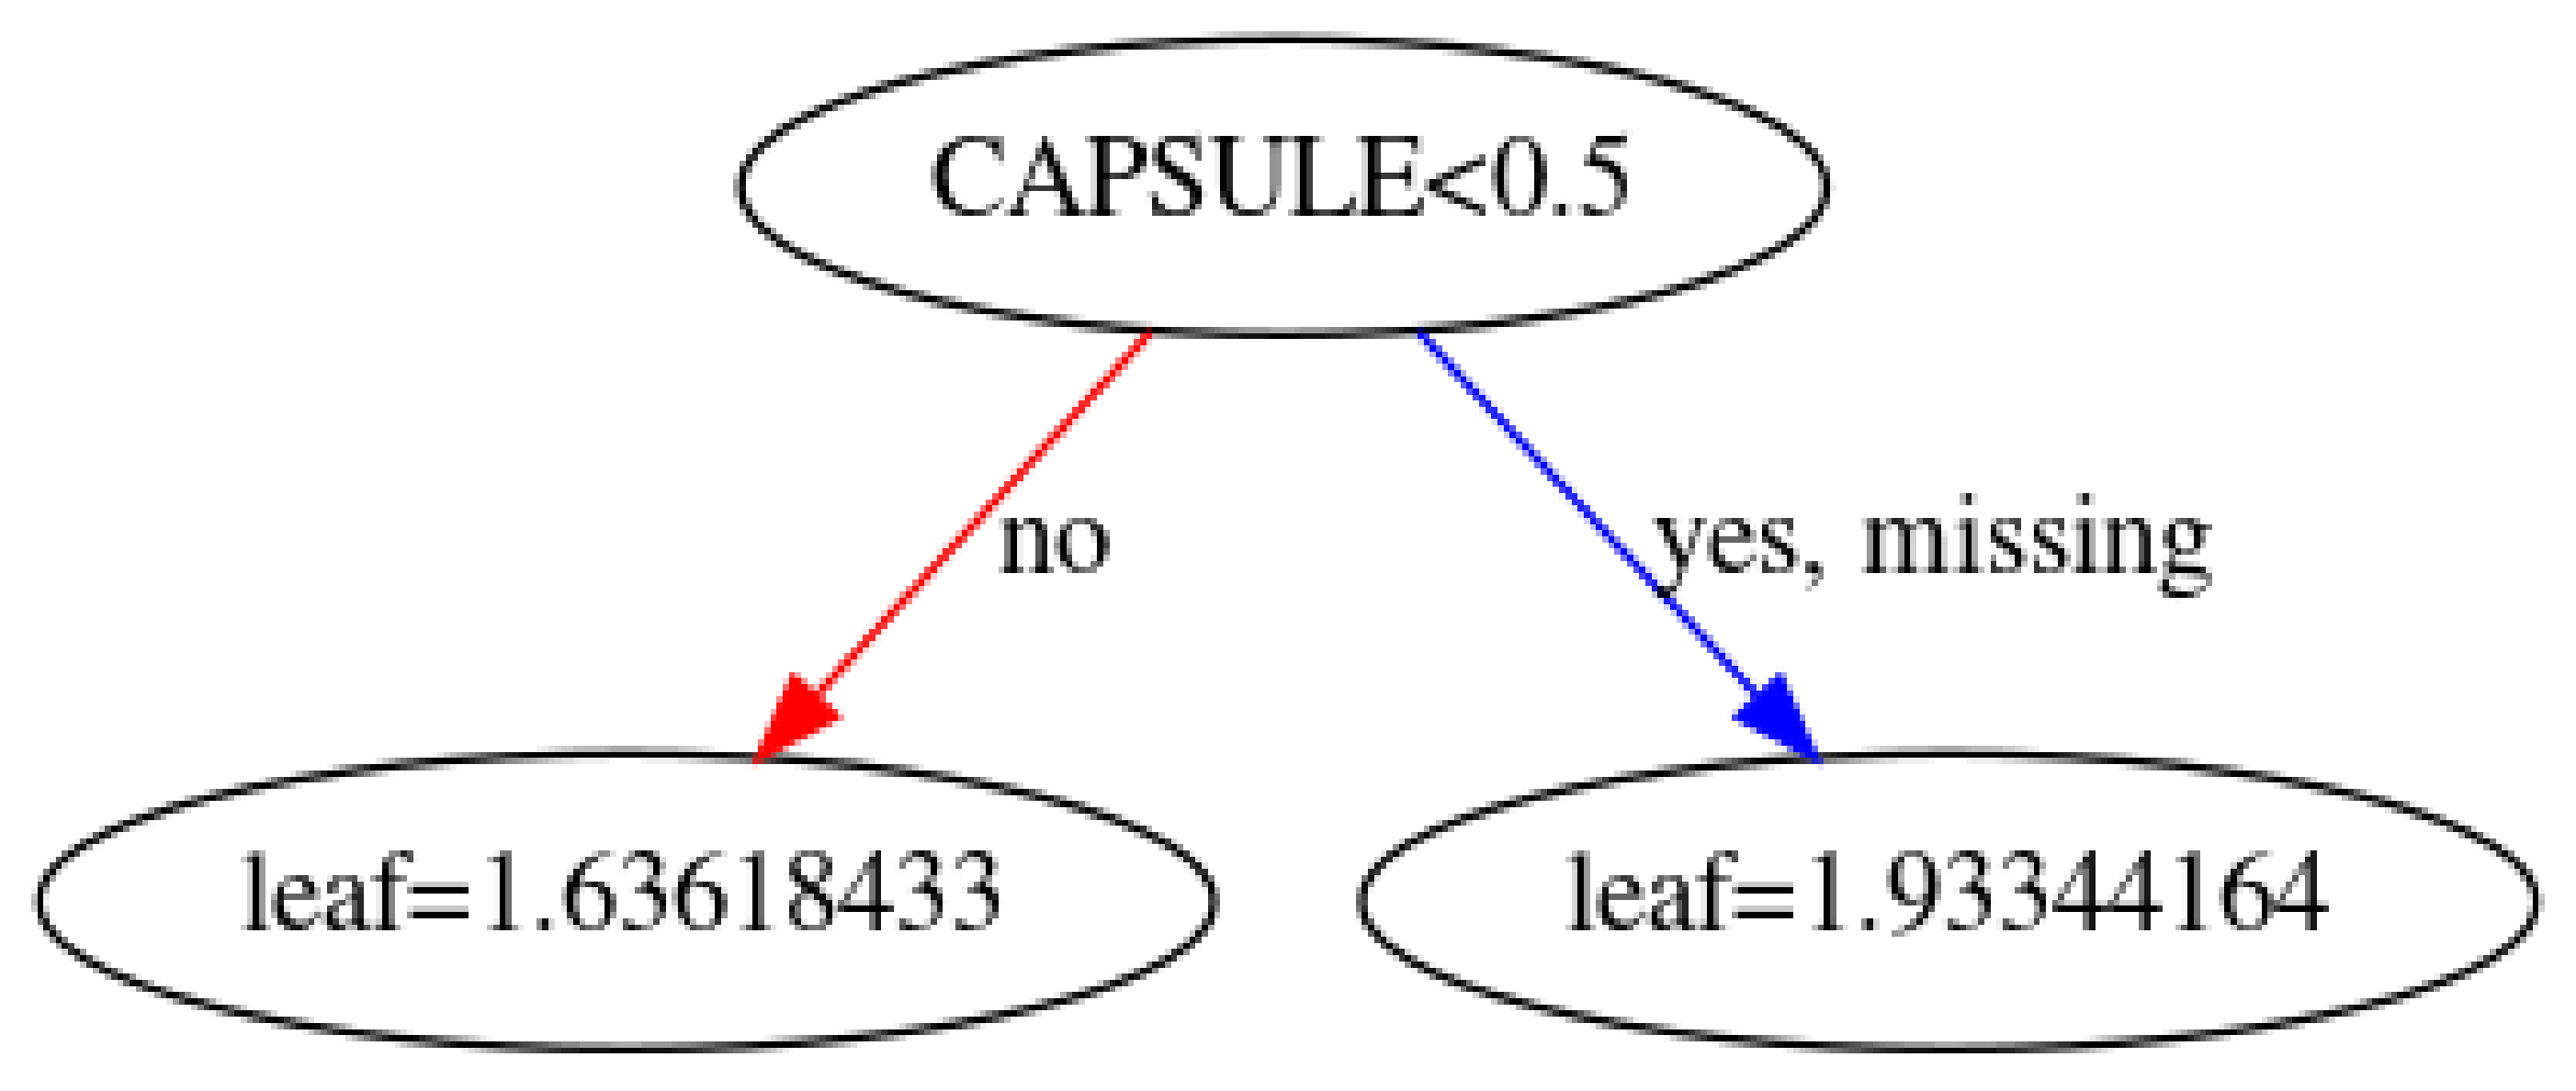

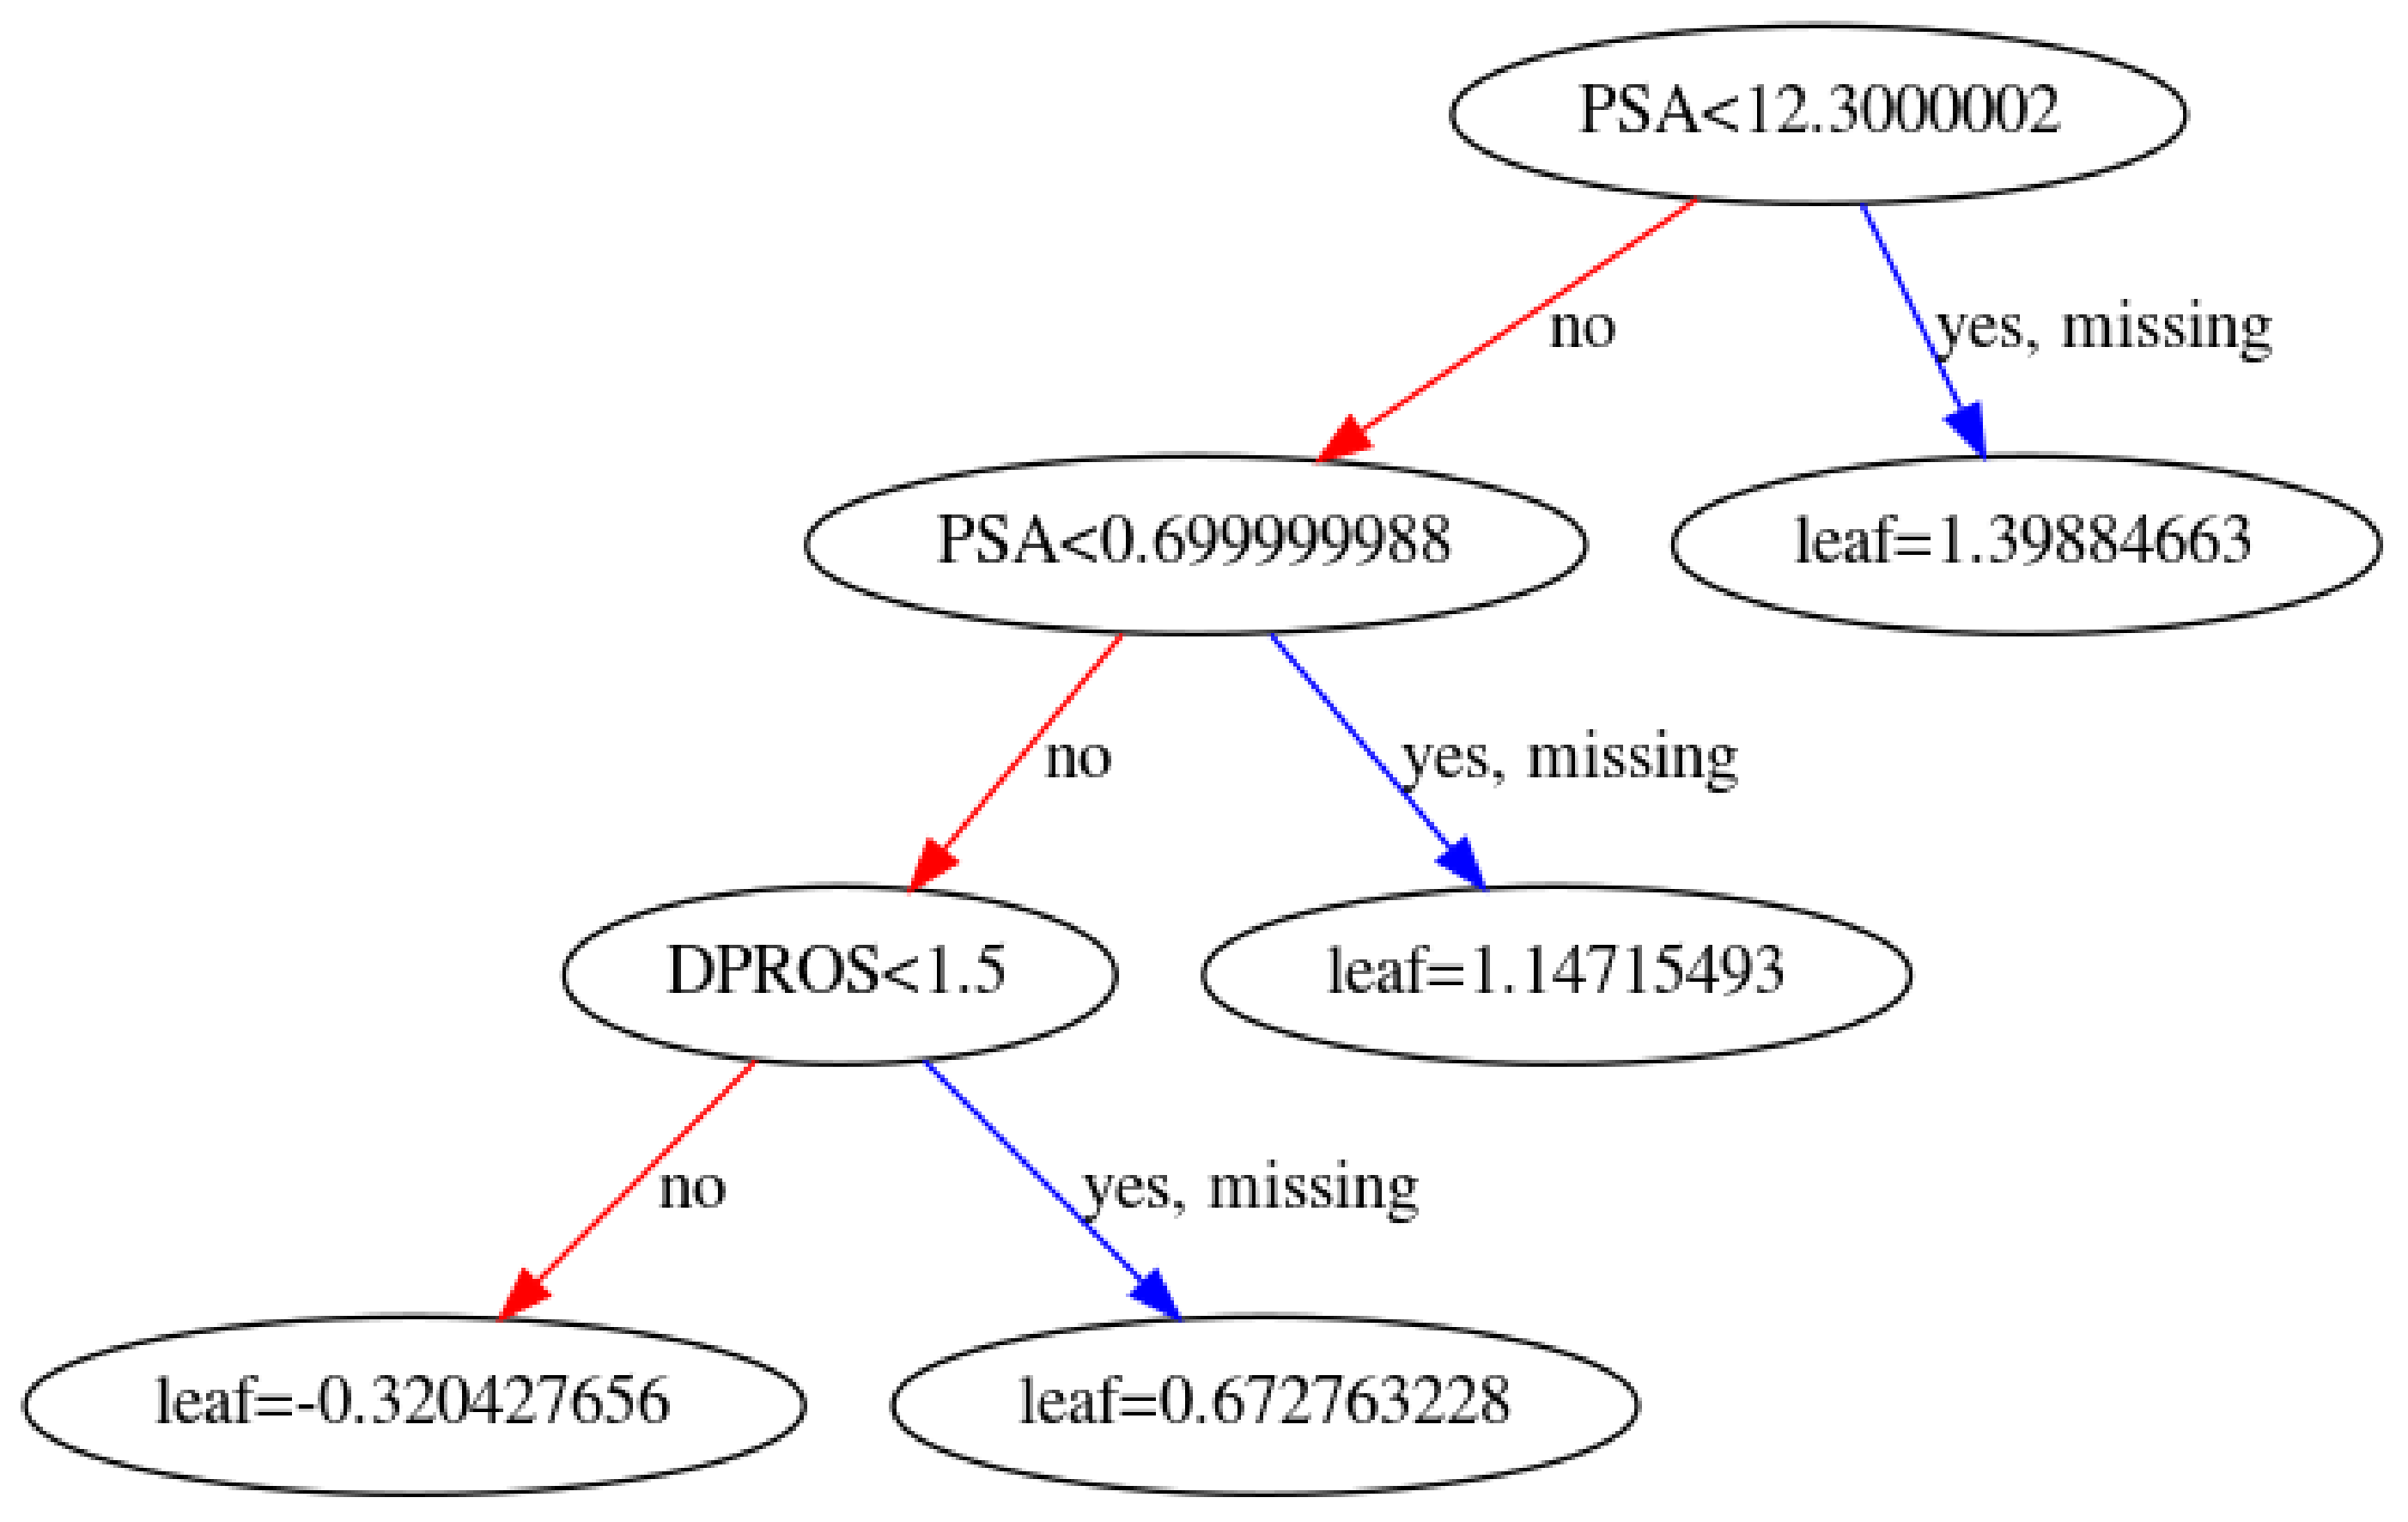

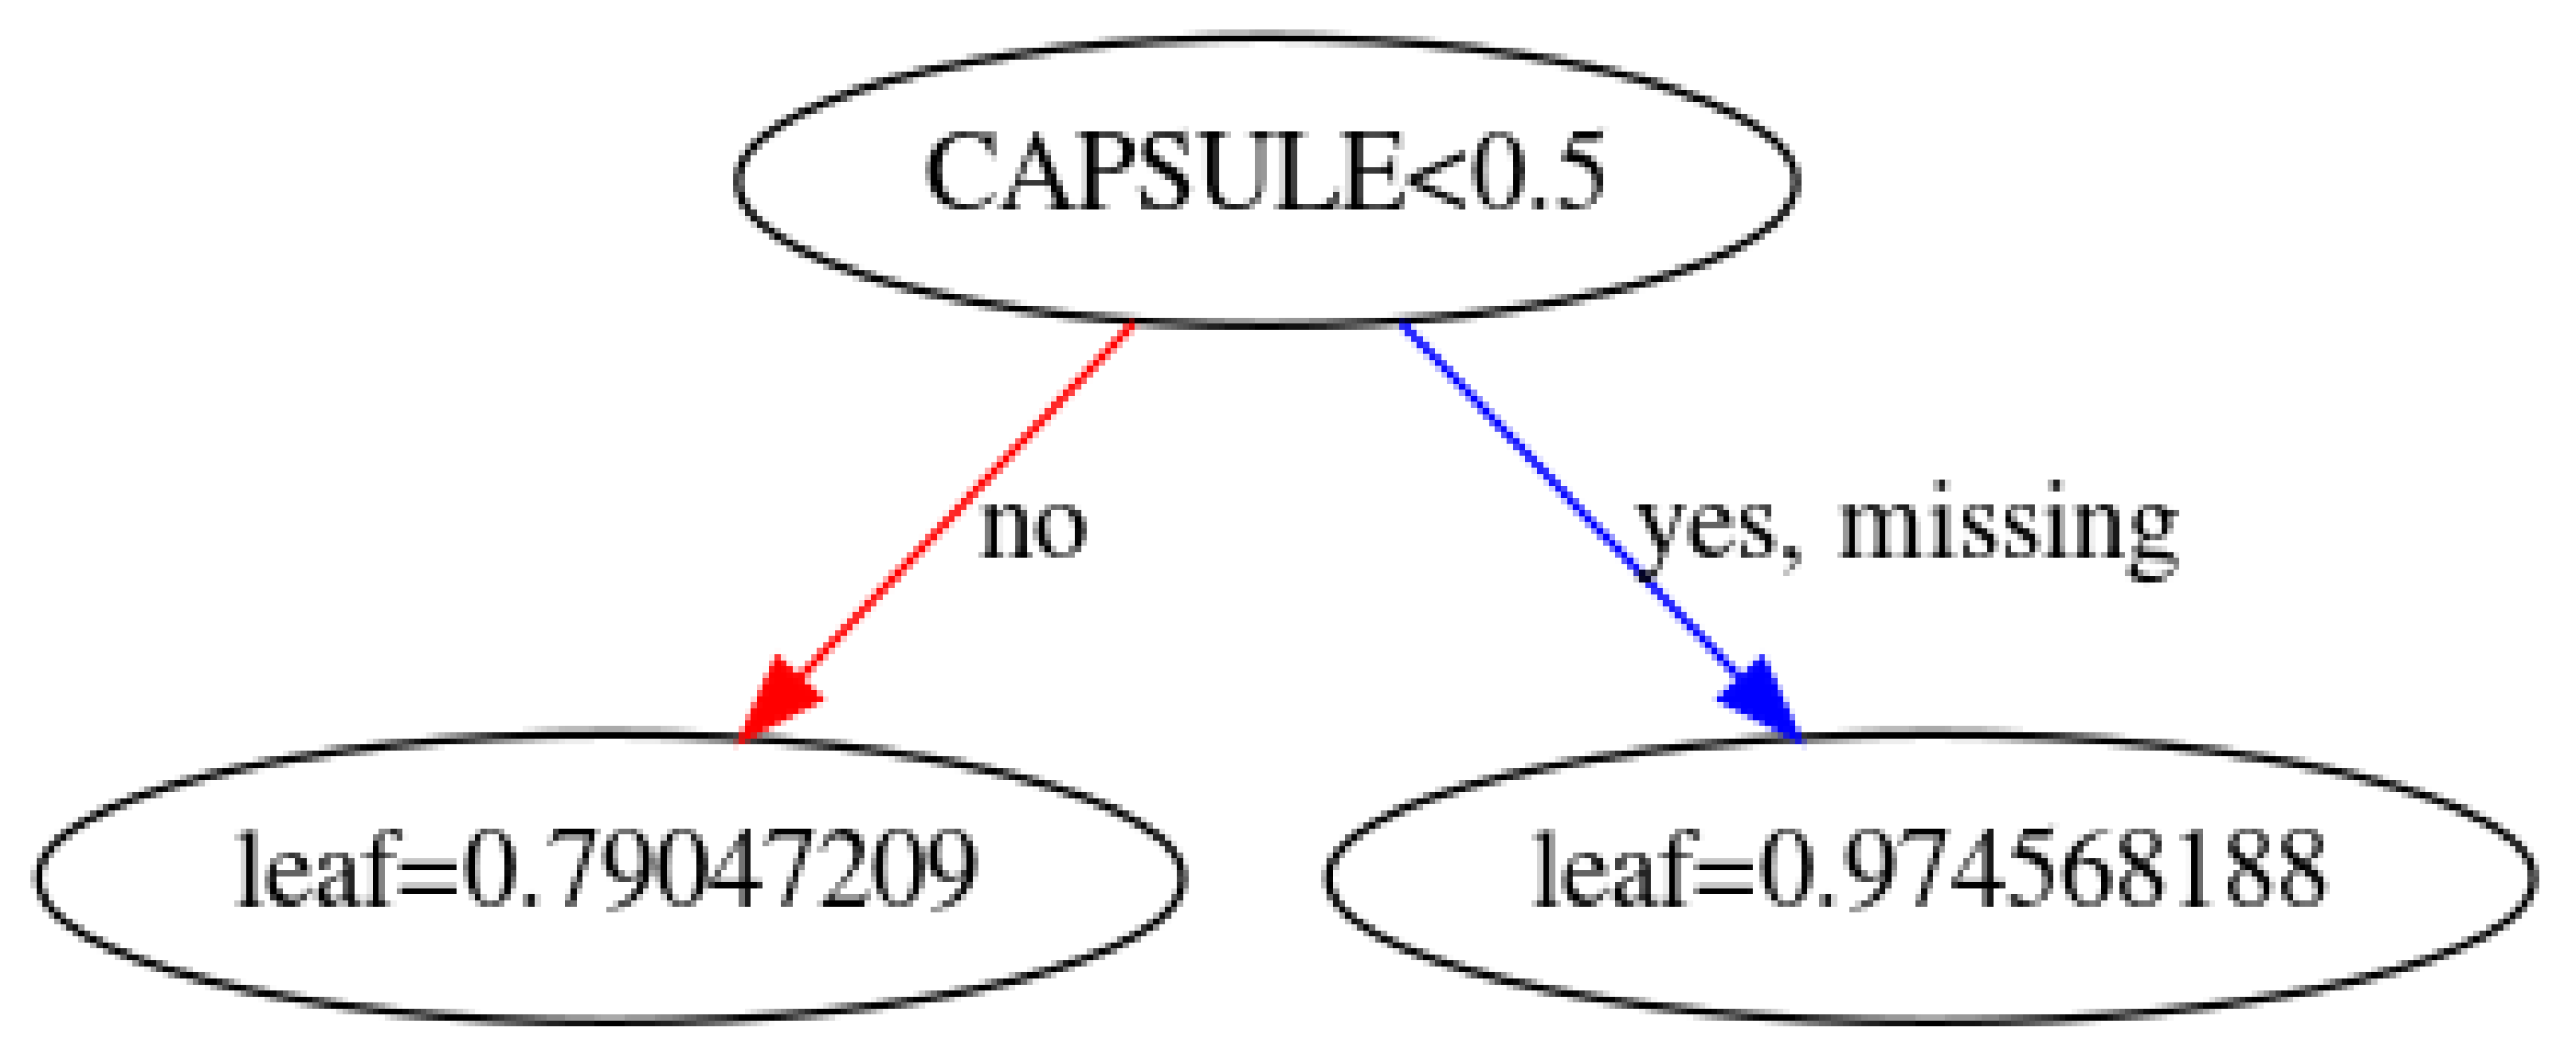

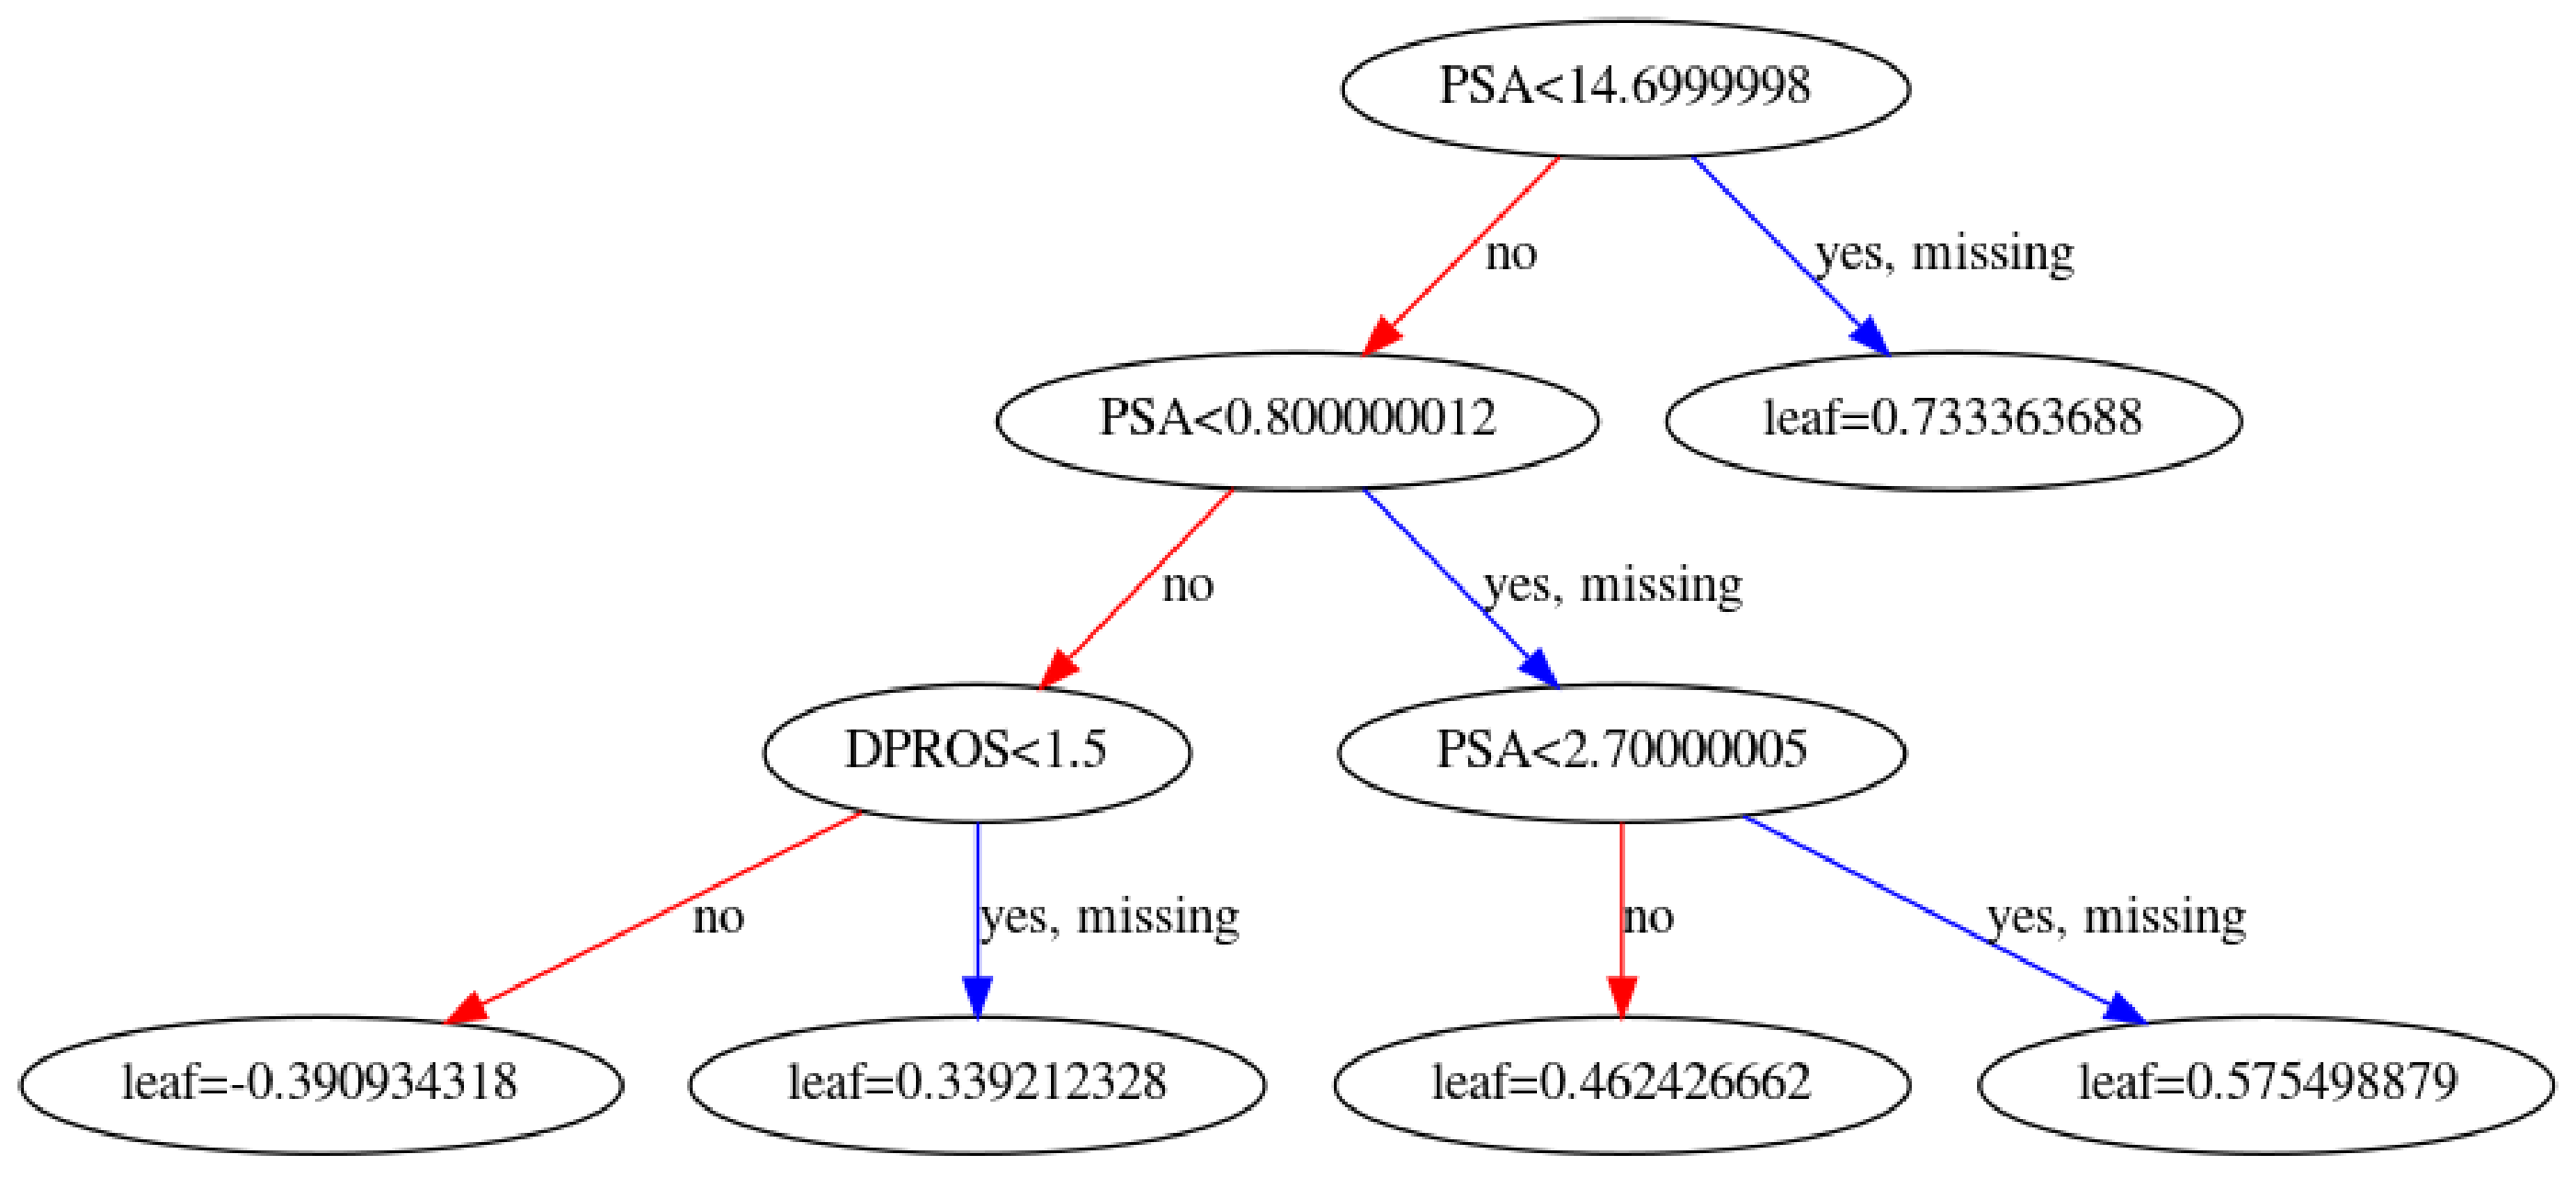

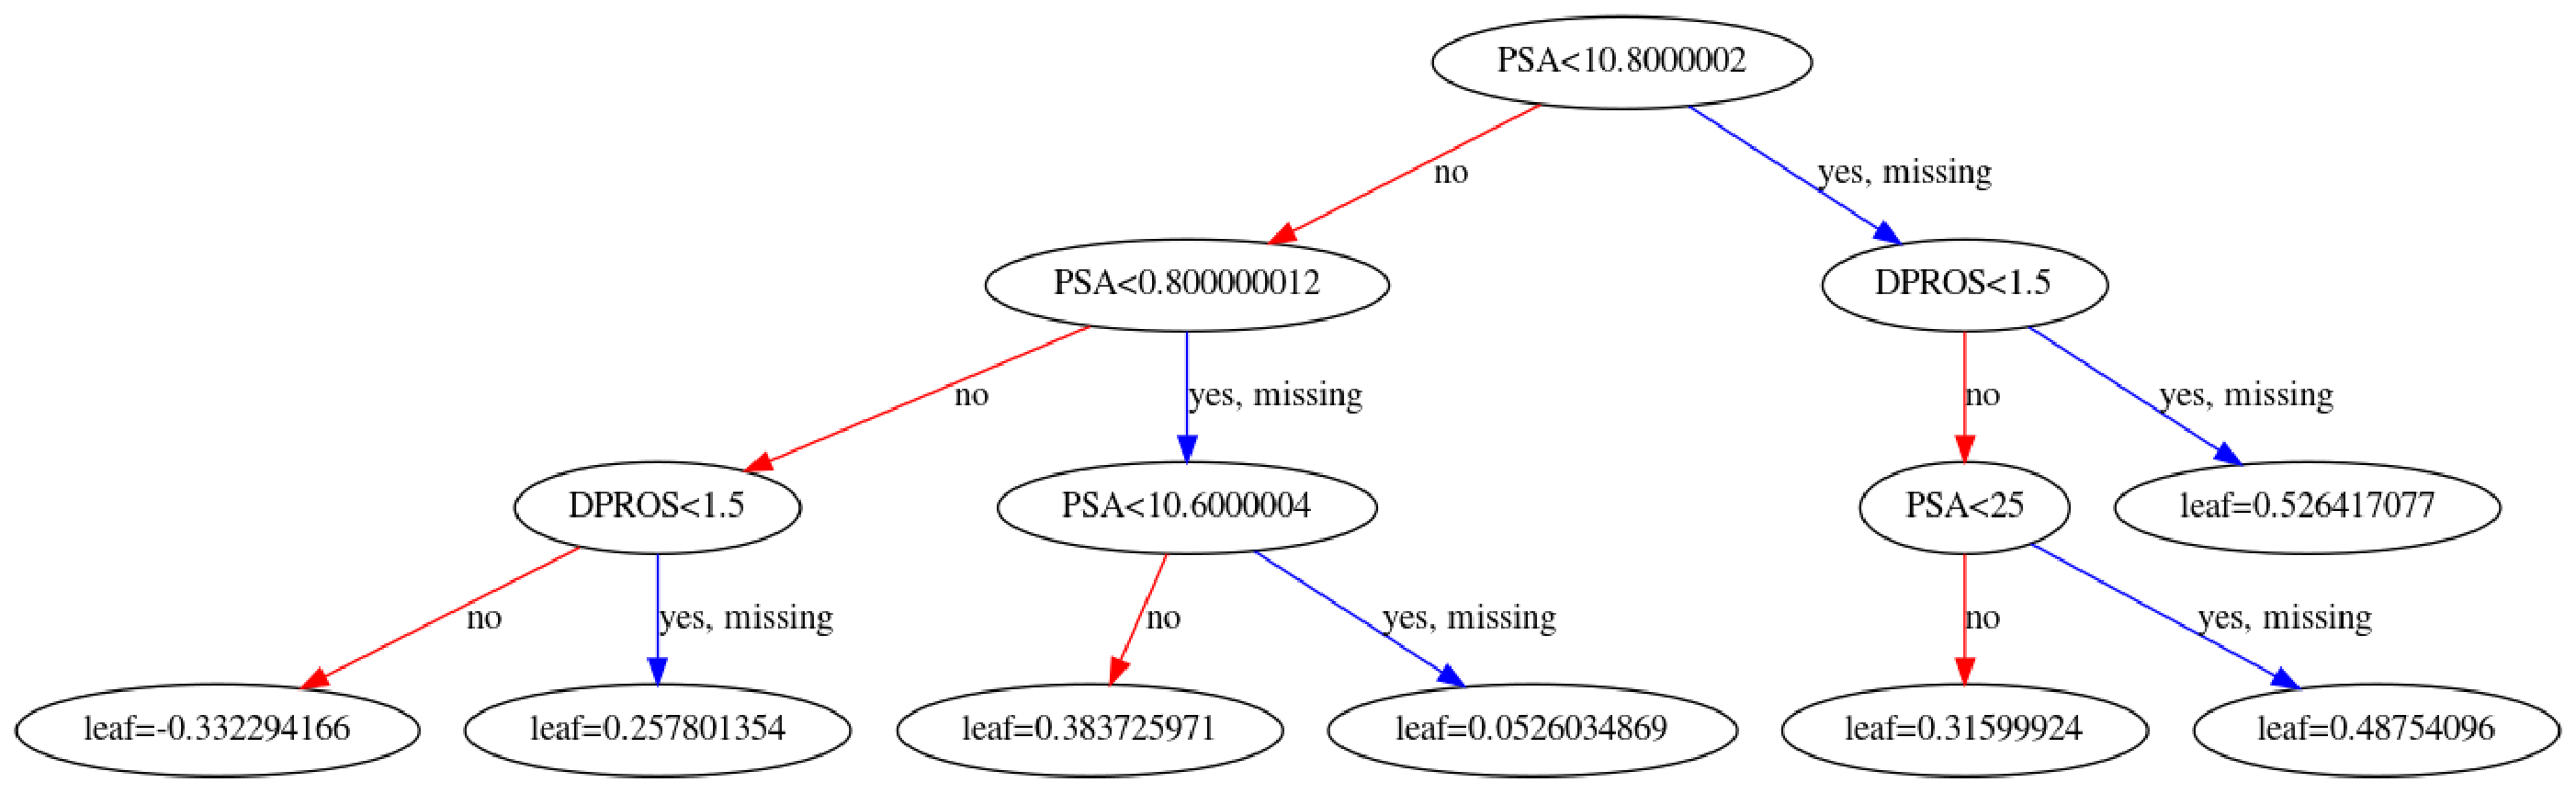

In [7]:
# plot xgboost trees
if xgboost_model is not None:
    from xgboost import plot_tree
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams

    rcParams['figure.figsize'] = 50, 80
    for i in range(0, ntree):
        plot_tree(xgboost_model, num_trees=i)

In [8]:
# show xgboost model variable importance
if xgboost_model is not None:
    print(xgboost_model.get_score(importance_type='total_gain'))

{'CAPSULE': 82.17504890000001, 'PSA': 112.98286059899998, 'DPROS': 29.485538920000003}


In [9]:
# show h2o xgboost model variable importance
h2o_model.varimp()

[('PSA', 112.98286437988281, 1.0, 0.5029430572294458),
 ('CAPSULE', 82.175048828125, 0.727323114696645, 0.3658021108991735),
 ('DPROS', 29.485538482666016, 0.260973543594422, 0.13125483187138065)]

## XGBFI-like Feature Interaction

In the code below, multiple table output provides comprendious insights into higher order interactions between the features of xgboost trees visualized above. Also additional usefull tables summarizing leaf statistics and split value histograms per each feature are provided. Measures used are either one of:

**Gain** is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite).

**Cover** measures the relative quantity of observations concerned by a feature.

**Frequency** is a simpler way to measure the Gain. It just counts the number of times a feature is used in all generated trees. You should not use it (unless you know why you want to use it).
(Source: https://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html)


or their averaged / weighed / ranked alternatives.



In [10]:
# calculate multi-level feature interactions
h2o_model.feature_interaction()


Interaction Depth 0: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,CAPSULE,82.175049,2.0,2.000000,1.000000,41.087524,82.175049,2.0,3.0,2.0,1.0,1.0,2.0,1.833333,1.0,0.00
1,,DPROS,29.485539,4.0,0.444737,0.111184,7.371385,1.803364,3.0,2.0,3.0,3.0,3.0,3.0,2.833333,3.0,1.75
2,,PSA,112.982861,9.0,6.313158,0.701462,12.553651,102.858399,1.0,1.0,1.0,2.0,2.0,1.0,1.333333,3.0,1.00



Interaction Depth 1: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,PSA|PSA,122.915955,5.0,3.221053,0.644211,24.583191,80.484941,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.4
1,,DPROS|PSA,71.868668,5.0,0.536842,0.107368,14.373734,7.733964,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.2,1.8



Interaction Depth 2: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,PSA|PSA|PSA,48.933441,2.0,1.276316,0.638158,24.466721,32.149829,2.0,2.0,1.0,1.0,2.0,1.0,1.5,3.5,2.0
1,,DPROS|PSA|PSA,153.497696,4.0,0.126316,0.031579,38.374424,3.009917,1.0,1.0,2.0,2.0,1.0,2.0,1.5,3.0,2.0



Leaf Statistics: 


,,interaction,sum_leaf_values_left,sum_leaf_values_right,sum_leaf_covers_left,sum_leaf_covers_right
0,,PSA|PSA,0.000000,1.147155,0.0,241.0
1,,CAPSULE,2.426656,2.908010,454.0,306.0
2,,PSA|PSA|PSA,0.846153,0.628102,253.0,232.0
3,,DPROS|PSA|PSA,-0.727657,1.757318,27.0,21.0
4,,PSA,0.000000,2.132210,0.0,245.0



CAPSULE Split Value Histogram: 


,,split_value,count
0,,1.0,2



DPROS Split Value Histogram: 


,,split_value,count
0,,2.0,4



PSA Split Value Histogram: 


,,split_value,count
0,,0.7,1
1,,0.8,2
2,,2.7,1
3,,10.6,1
4,,10.8,1
5,,12.3,1
6,,14.7,1
7,,25.0,1


[, , , , , , ]